Links to other notebooks in the same folder:
<a href='http://pivotal.io/data-science'><img src='https://raw.githubusercontent.com/crawles/Logos/master/Pivotal_TealOnWhite.png' width='200px' align='right'></a>

<nav class = "navbar navbar-light bg-faded">
    <ul class = "nav navbar-nav">
        <li class = "">
            <a class = "nav-link">notebook1</a>
        </li>
        <li class = "">
            <a class = "nav-link">notebook2</a>
        </li>
        <li class = "">
            <a class = "nav-link">notebook3</a>
        </li>
        

# Load Libraries and Set Default Settings

In [1]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import getopt
from IPython.core.display import display, HTML
import os
import sys
import urllib

from IPython.core.magic import register_line_magic, register_cell_magic, register_line_cell_magic
from IPython.display import display
from IPython.display import HTML
%matplotlib inline
# If we want to move the graph
# %matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import psycopg2
import seaborn as sns

# Credentials file to connect to database
import credentials
from sql_functions import *
from mpp_plotting_functions import *

/Users/gregorytam/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Changes logo to a Pivotal logo
jPrefs = urllib.urlopen("https://raw.githubusercontent.com/crawles/Logos/master/jupyterPrefs.js").read()
HTML('<script>{}</script>'.format(jPrefs))

In [3]:
# Set default cell width
display(HTML('<style>.container {width:80% !important;}</style>'))

# Set default matplotlib settings
mpl.rcParams['figure.figsize'] = (10, 7)
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['figure.titlesize'] = 26
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 16

# Set Seaborn Colours
blue, green, red, purple, yellow, cyan = sns.color_palette()

# Connect to Database

In [4]:
conn = psycopg2.connect(**credentials.login_info_dict)
conn.autocommit = True
psql.execute('SET search_path TO template;', conn)

<cursor object at 0x119399718; closed: 0>

# Define magic functions - helpful for interacting with cluster

In [5]:
@register_cell_magic
def readsql(line, cell):
    """
    Extract the code in the specific cell (should be valid SQL), 
    and execute it using the connection object to the backend 
    database. The resulting pandas DataFrame is rendered inline 
    below the cell using IPython.display. You'd use this for SELECT.
    
    Returns a DataFrame with the name specified in the magic
    function. If this is not specified, then the DataFrame
    is called _df. This also takes in an option "-h", followed 
    by a number. This will show only the specified number of rows
    in the DataFrame.
    """
    # Use the global connection object defined above.
    global conn
    optlist, args = getopt.getopt(line.split(), 'h:')
    optdict = dict(optlist)
    if '-h' in optdict:
        head_num = optdict['-h']
    elif len(optdict) == 0:
        head_num = 0
    
    # If there is more than one table name specified,
    # throw an exception.
    if len(args) > 1:
        raise Exception('More than one table name specified')

    elif len(args) == 1:
        # If a table name is specified, store it as that
        table_name = args[0]
        globals()[table_name] = psql.read_sql(cell.format(**globals()), conn)
        if '-h' in optdict:
            display(globals()[table_name].head(int(optdict['-h'])))
        else:
            display(globals()[table_name])

    else:
        # Otherwise, call it _df
        global _df
        _df = psql.read_sql(cell.format(**globals()), conn)
        if '-h' in optdict:
            display(_df.head(int(optdict['-h'])))
        else:
            display(_df)

@register_cell_magic
def execsql(line, cell):
    """
    Extract the code in the specific cell (should be valid SQL),
    and execute it using the connection object to the backend 
    database. You'd use this for CREATE/UPDATE/DELETE.
    """
    # Use the global connection object defined above.
    global conn
    psql.execute(cell.format(**globals()), conn)

@register_cell_magic
def printsql(line, cell):
    """
    Show the SQL query that will be run.
    """
    print cell.format(**globals())

# We delete these to avoid name conflicts for automagic to work
del execsql, readsql, printsql

# Creating Fake Data

Begin by creating random fake data in our database. We will add some NULL rows too.

In [6]:
%%execsql
DROP TABLE IF EXISTS test_data;
CREATE TABLE test_data
   AS SELECT random()^2 * 50 AS log_col,
             50 - random()^2 * 50 AS log_col_2,
             (random()^2 * 50)::INT AS log_col_int,
             CASE WHEN random() < 0.5 THEN 'category_a'
                  WHEN random() < 0.7 THEN 'category_b'
                  WHEN random() < 0.85 THEN 'category_c'
                  WHEN random() < 0.95 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_1,
             CASE WHEN random() < 0.2 THEN 'category_a'
                  WHEN random() < 0.4 THEN 'category_b'
                  WHEN random() < 0.6 THEN 'category_c'
                  WHEN random() < 0.8 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_2,
             CASE WHEN random() < 0.2 THEN 'category_a'
                  WHEN random() < 0.4 THEN 'category_b'
                  WHEN random() < 0.65 THEN 'category_c'
                  WHEN random() < 0.95 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_3,
             (random()*100 + 50)::text AS uncasted_col
        FROM generate_series(1, 10000)
       UNION ALL
      SELECT NULL AS log_col,
             50 - random()^2 * 50 AS log_col_2,
             (random()^2 * 50)::INT AS log_col_int,
             NULL AS category_1,
             CASE WHEN random() < 0.2 THEN 'category_a'
                  WHEN random() < 0.4 THEN 'category_b'
                  WHEN random() < 0.6 THEN 'category_c'
                  WHEN random() < 0.8 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_2,
             NULL AS category_3,
             NULL AS uncasted_col
        FROM generate_series(1, 1000);
        

DROP TABLE IF EXISTS small_test_data;
CREATE TABLE small_test_data
   AS SELECT random()^2 * 50 AS log_col,
             50 - random()^2 * 50 AS log_col_2,
             (random()^2 * 50)::INT AS log_col_int,
             CASE WHEN random() < 0.5 THEN 'category_a'
                  WHEN random() < 0.7 THEN 'category_b'
                  WHEN random() < 0.85 THEN 'category_c'
                  WHEN random() < 0.95 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_1,
             CASE WHEN random() < 0.2 THEN 'category_a'
                  WHEN random() < 0.4 THEN 'category_b'
                  WHEN random() < 0.6 THEN 'category_c'
                  WHEN random() < 0.8 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_2,
             CASE WHEN random() < 0.2 THEN 'category_a'
                  WHEN random() < 0.4 THEN 'category_b'
                  WHEN random() < 0.65 THEN 'category_c'
                  WHEN random() < 0.95 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_3,
             (random()*100 + 50)::text AS uncasted_col
        FROM generate_series(1, 1000)
       UNION ALL
      SELECT NULL AS log_col,
             50 - random()^2 * 50 AS log_col_2,
             (random()^2 * 50)::INT AS log_col_int,
             NULL AS category_1,
             CASE WHEN random() < 0.2 THEN 'category_a'
                  WHEN random() < 0.4 THEN 'category_b'
                  WHEN random() < 0.6 THEN 'category_c'
                  WHEN random() < 0.8 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_2,
             NULL AS category_3,
             NULL AS uncasted_col
        FROM generate_series(1, 100);

In [7]:
%%readsql
SELECT *
  FROM test_data
 LIMIT 10;

,log_col,log_col_2,log_col_int,category_1,category_2,category_3,uncasted_col
0,28.922572,0.882172,42,category_a,category_a,category_a,113.714485242963
1,24.003119,1.819940,40,category_b,category_e,category_d,140.546911768615
2,0.027765,29.380643,21,category_c,category_a,category_c,111.735903518274
3,31.510253,35.441219,19,category_b,category_c,category_a,89.7981584537774
4,27.775880,40.532885,4,category_b,category_a,category_b,132.845964236185
5,5.343966,49.203716,11,category_c,category_c,category_d,59.1687654145062
6,13.844056,46.353032,22,category_c,category_b,category_b,109.678009385243
7,22.845696,26.361284,25,category_a,category_c,category_b,90.2624206151813
8,30.569331,40.345673,1,category_c,category_d,category_a,75.2196365967393
9,0.013235,5.712668,1,category_a,category_c,category_b,134.292940888554


# Plotting Categorical Histograms
We can first get the histogram values for categorical data. This is as simple as taking a group by and then counting. The <code>get_histogram_values</code> function will achieve this by running it in the backend.

In [8]:
category_hist_df = get_histogram_values('test_data', 'category_1', conn, nbins=25)
category_hist_df_2 = get_histogram_values('test_data', 'category_2', conn, nbins=25)

By default, this will take the table in whichever schema name was set. If we want to specify a table with the same name from a different schema, we can either set the schema again or simply prepend the table name with the schema name and a period (i.e. schema_name.table_name)

In [9]:
category_hist_df = get_histogram_values('template.test_data', 'category_1', conn, nbins=25)
category_hist_df_2 = get_histogram_values('template.test_data', 'category_2', conn, nbins=25)

This table is simply a pandas DataFrame of each of the categories and their respective counts. We can use this DataFrame in conjunction with our plotting functions.

In [10]:
display(category_hist_df)
display(category_hist_df_2)

,category,freq
0,category_a,4949
1,category_b,3516
2,category_c,1317
3,None,1000
4,category_d,205
5,category_e,13


,category,freq
0,category_b,3516
1,category_c,3116
2,category_a,2233
3,category_d,1665
4,category_e,470


## Plotting a Single Variable
We can use the <code>plot_categorical_hists</code> function to plot one or multiple histograms for categorical variables. If there are any null values in the column, we can specify where we want to place them (on the left or right, in order, or simply ignore it). We can also specify our ordering (ascending or descending and alphatically or by frequency). 

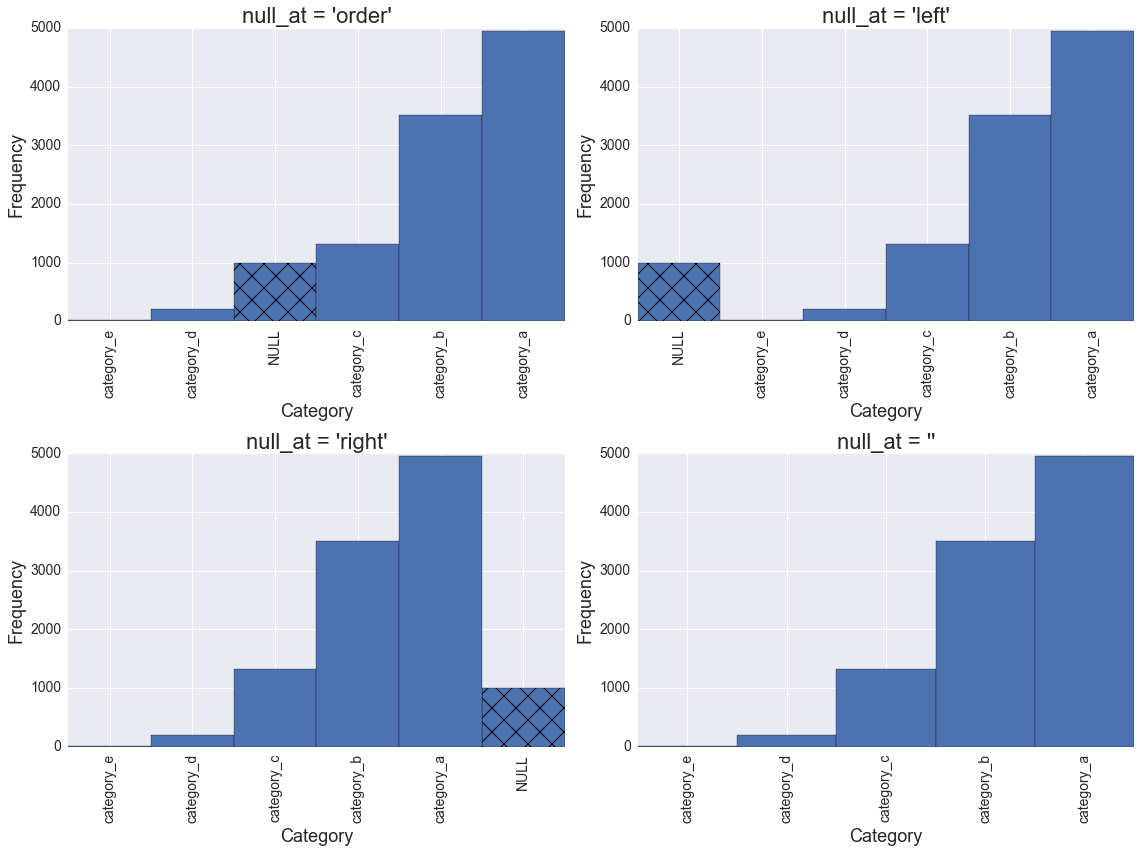

In [11]:
null_at_list = ['order', 'left', 'right', '']
plt.figure(figsize=(16, 12))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plot_categorical_hists(category_hist_df,
                           null_at=null_at_list[i],
                           order_by=0,
                           ascending=True
                          )
    plt.title("null_at = '{}'".format(null_at_list[i]))
    plt.xlabel('Category')
    plt.ylabel('Frequency')

plt.tight_layout()

## Plotting Multiple Histograms
We can similarly plot multiply histograms together on the same plot. We specify our ordering in the same manner, except we choose which histogram we want to order by. This is done by setting the index of the histogram we wish to order by. 

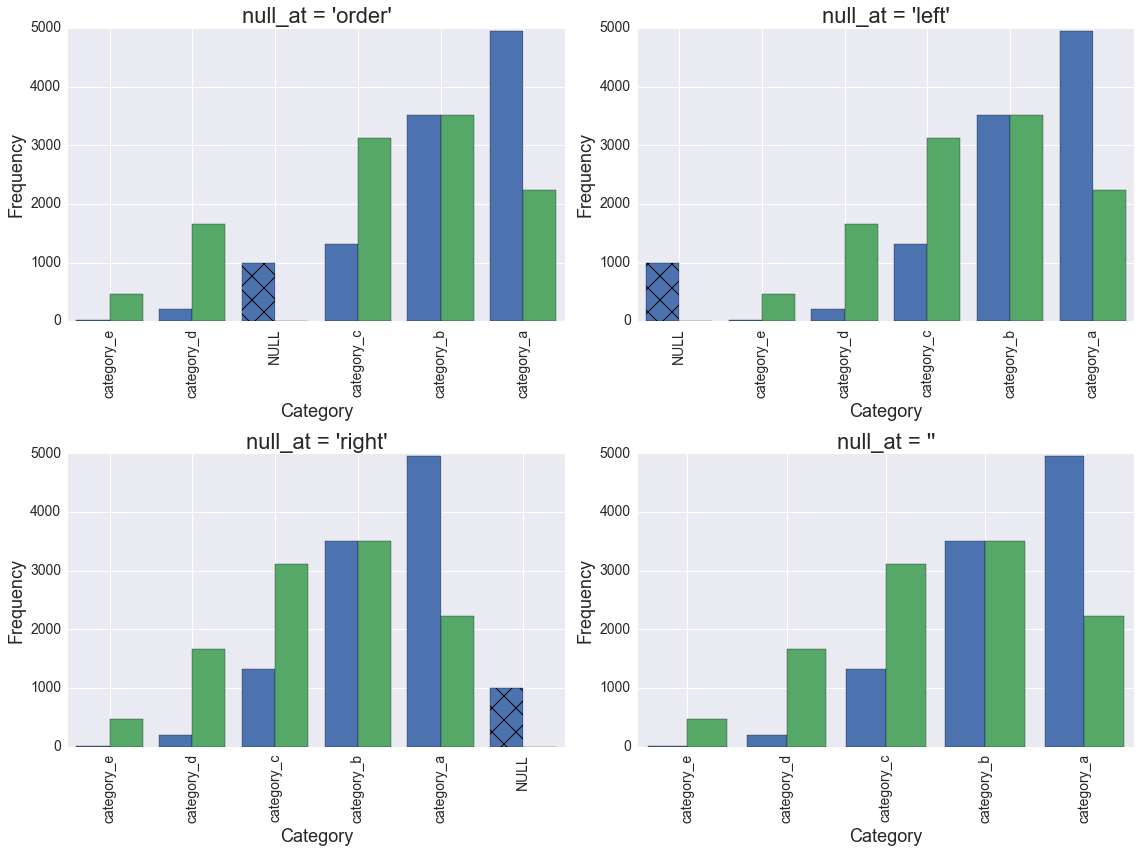

In [12]:
null_at_list = ['order', 'left', 'right', '']
plt.figure(figsize=(16, 12))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plot_categorical_hists([category_hist_df, category_hist_df_2],
                           null_at=null_at_list[i],
                           order_by=0,
                           ascending=True
                          )
    plt.title("null_at = '{}'".format(null_at_list[i]))
    plt.xlabel('Category')
    plt.ylabel('Frequency')

plt.tight_layout()

# Plot the Numerical Histograms
Plotting numerical variables is a bit trickier since we cannot do a simple group by. Instead, we can calculate our histogram and scatterplot bins via a formula then group by these bins.

$$\text{bin_num}(x) = \frac{1}{n_{bins}} \left\lfloor \frac{x-\min(x)}{\max(x) - \min(x) + \varepsilon} * n_{bins} \right\rfloor  \times \left\{\max(x) - \min(x)\right\} + \min(x)$$
The variable $\varepsilon>0$ is a small number. This ensures that the fraction in the floor function is never equal to 1. This would happen in the case that $x$ is equal to the maximum and we would have a bin with potetially only one value (i.e., the max value).

In [13]:
log_hist_df = get_histogram_values('test_data', 'log_col', conn, nbins=25)
log_hist_df_2 = get_histogram_values('test_data', 'log_col_2', conn, nbins=25)

## Plotting a Single Histogram
Plotting a single numerical histogram works the same as before, except that we cannot specify our null values to be in order since this is a histogram.

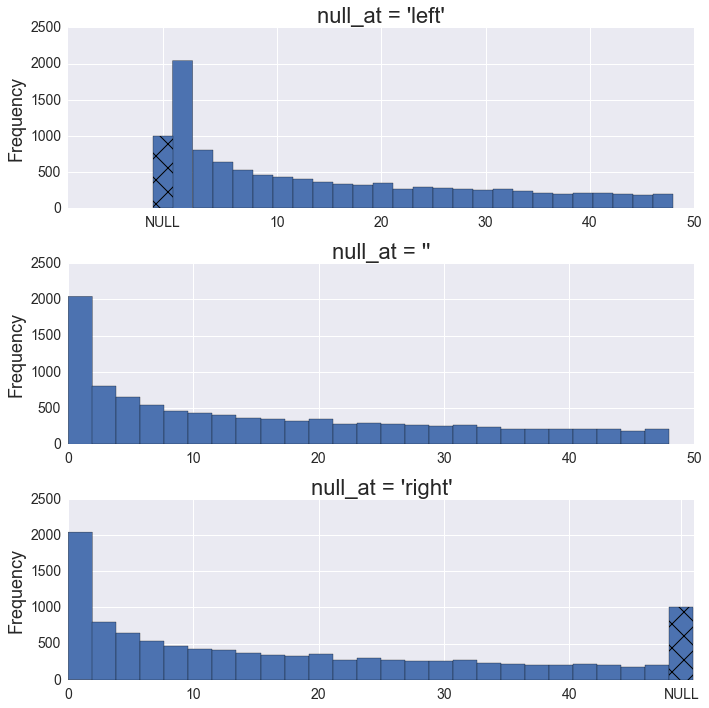

In [14]:
plt.figure(figsize=(10, 10))

plt.subplot(311)
plot_numeric_hists([log_hist_df], nbins=25, null_at='left')
plt.title("null_at = 'left'")
plt.ylabel('Frequency')

plt.subplot(312)
plot_numeric_hists([log_hist_df], nbins=25, null_at='')
plt.title("null_at = ''")
plt.ylabel('Frequency')

plt.subplot(313)
plot_numeric_hists([log_hist_df], nbins=25, null_at='right')
plt.title("null_at = 'right'")
plt.ylabel('Frequency')

plt.tight_layout()

## Plotting Multiple Histograms
Plotting more than one histogram works the same as before.

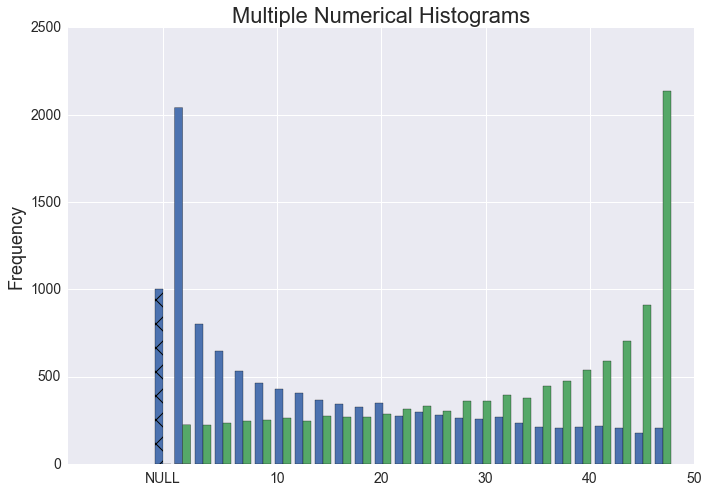

In [15]:
plot_numeric_hists([log_hist_df, log_hist_df_2], nbins=25, null_at='left')
plt.title('Multiple Numerical Histograms')
plt.ylabel('Frequency')
plt.tight_layout()

## Recasting values
If a numeric field is misrepresented as text.

In [16]:
recasted_hist_df = get_histogram_values('test_data', 'uncasted_col', conn, nbins=25, cast_as='float')

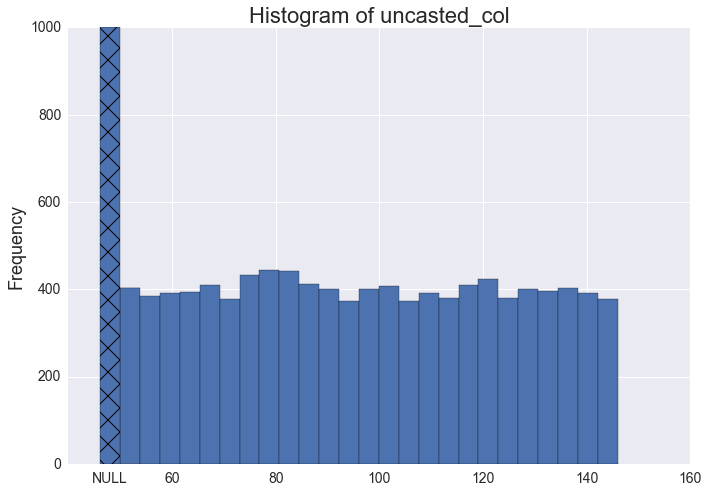

In [17]:
plot_numeric_hists(recasted_hist_df, nbins=25)
plt.title('Histogram of uncasted_col')
plt.ylabel('Frequency')
plt.tight_layout()

## Plotting on a log scale

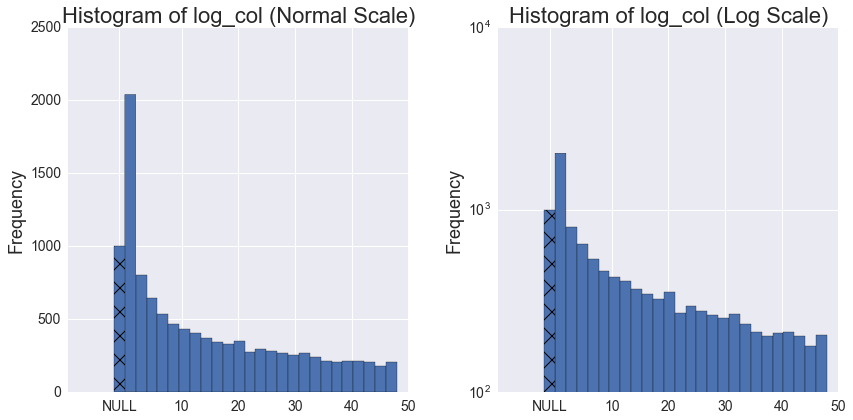

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_numeric_hists(log_hist_df, nbins=25, log=False)
plt.title('Histogram of log_col (Normal Scale)')
plt.ylabel('Frequency')

plt.subplot(122)
plot_numeric_hists(log_hist_df, nbins=25, log=True)
plt.title('Histogram of log_col (Log Scale)')
plt.ylabel('Frequency')

plt.tight_layout()

## Specifying Bin Width

In [19]:
log_int_hist_df = get_histogram_values('test_data', 'log_col_int', conn, bin_width=5)

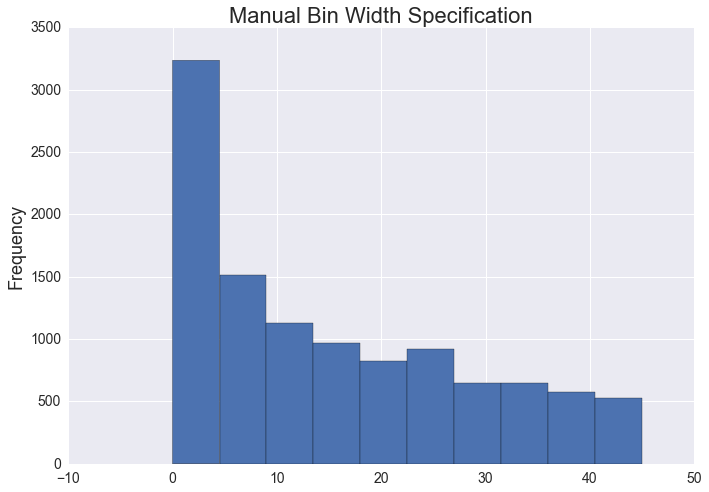

In [20]:
plot_numeric_hists(log_int_hist_df, nbins=log_int_hist_df.shape[0])
plt.title('Manual Bin Width Specification')
plt.ylabel('Frequency')
plt.tight_layout()

## Normalizing Plots
If we are plotting two or more histograms, they may be at different scales. For example, if we want to plot two histograms, but one has many more instances than the other, the smaller data set will not be visible on the histogram.

In [21]:
log_hist_df_small = get_histogram_values('small_test_data', 'log_col', conn, nbins=25)

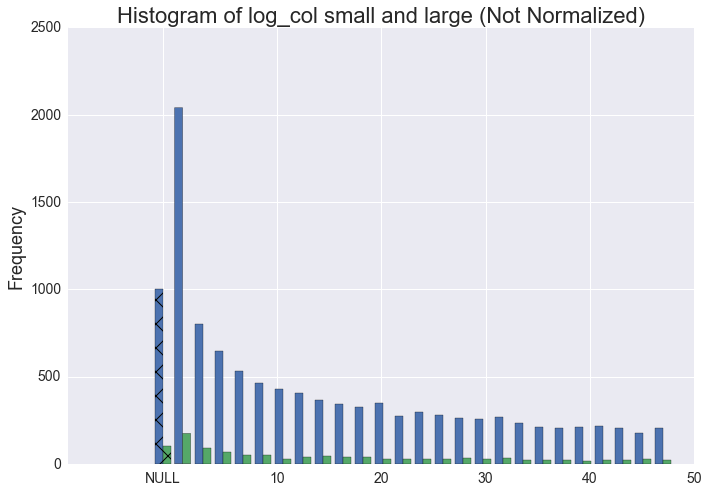

In [22]:
plot_numeric_hists([log_hist_df, log_hist_df_small], nbins=25, normed=False)
plt.title('Histogram of log_col small and large (Not Normalized)')
plt.ylabel('Frequency')
plt.tight_layout()

The above plot illustrates the green, which is much smaller. There are a couple of things we can do. First, we can put everything onto the log scale.

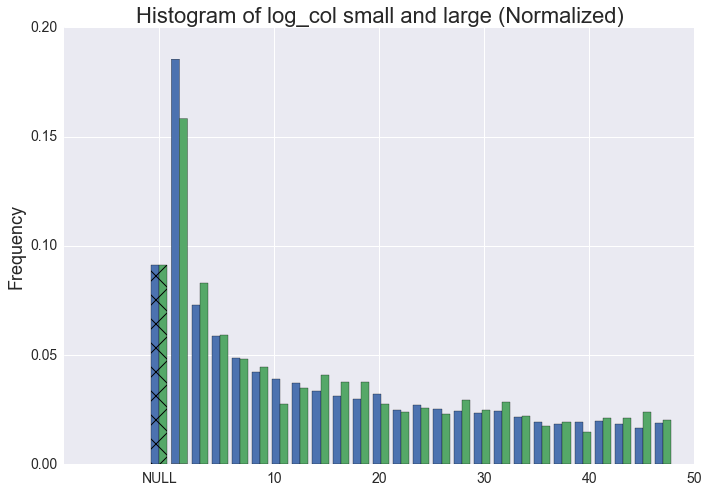

In [23]:
plot_numeric_hists([log_hist_df, log_hist_df_small], nbins=25, normed=True)
plt.title('Histogram of log_col small and large (Normalized)')
plt.ylabel('Frequency')
plt.tight_layout()

# Plot the Summarized Data as a Scatter Plot
We can also plot scatter plots in a similar manner to our histograms. However, we instead bin on the <code>x</code> and <code>y</code> axes independently. Then for each bin, we can plot a dot with its size proportional to the number of observations found in that bin.

## Make Sizes Relative to Amount of Data

In [24]:
scatter_df = get_scatterplot_values('test_data', 'log_col', 'log_col_2', conn, bin_size=(1, 1))

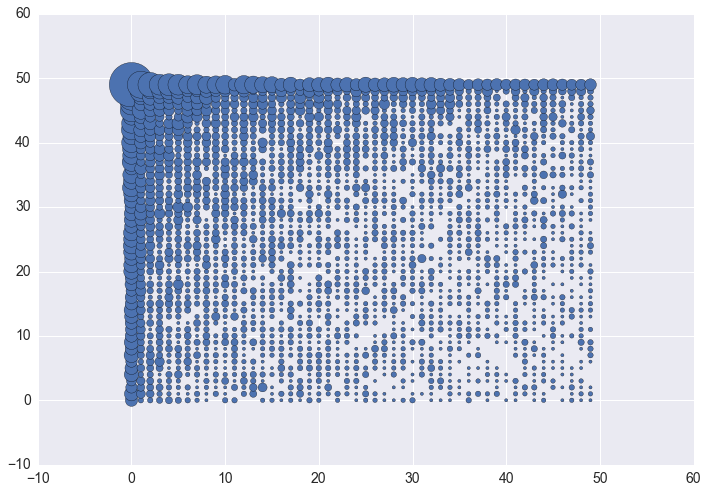

In [25]:
plt.scatter(scatter_df.bin_nbr_x, scatter_df.bin_nbr_y, c=blue, s=10*scatter_df.freq)
plt.tight_layout()

## Add Opacity
We may also add opacity.

In [26]:
colour_matrix = np.zeros((scatter_df.dropna().shape[0], 4))
colour_matrix[:, :3] = blue
# Add alpha component
colour_matrix[:, 3] = scatter_df.dropna().freq/np.max(scatter_df.dropna().freq)

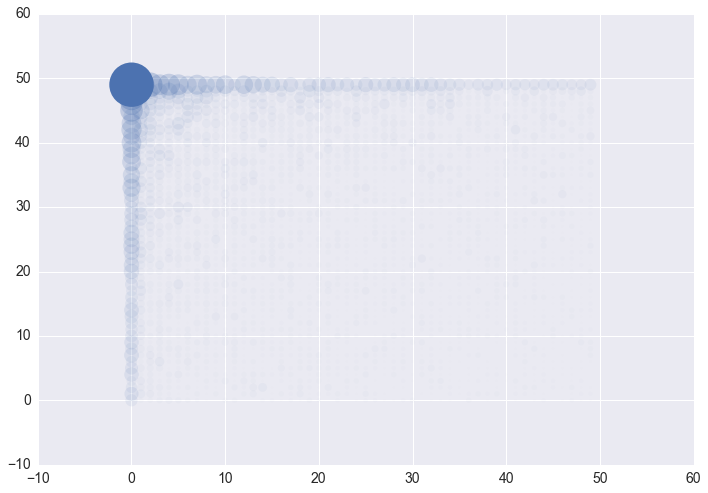

In [27]:
plt.scatter(scatter_df.bin_nbr_x, scatter_df.bin_nbr_y, c=colour_matrix, lw=0, s=10*scatter_df.freq)
plt.tight_layout()

# Casting
We can also cast values as before.

In [28]:
recasted_scatter_df = get_scatterplot_values('test_data', 'log_col', 'uncasted_col', conn, nbins=(50, 50), cast_y_as='float')

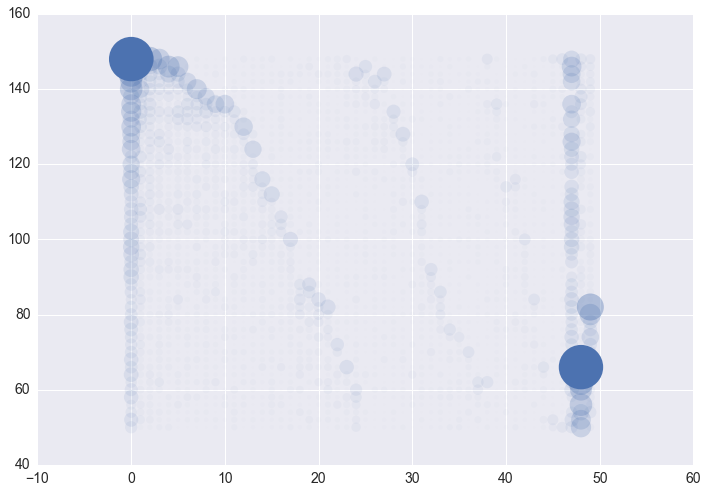

In [29]:
plt.scatter(recasted_scatter_df.bin_nbr_x, recasted_scatter_df.bin_nbr_y, c=colour_matrix, lw=0, s=10*scatter_df.freq)
plt.tight_layout()

TODO: Fix Opacity